# Content Design for RAG

This notebook is part of a collection of material related to content design principles for retrieval-augmented generation (RAG).

You can explore the complete collection here: [Content Design for RAG on GitHub](https://github.com/spackows/ICAAI-2024_RAG-CD/blob/main/README.md)

## Compare RAGAs question-answer relevance metric with manual evaluation

RAGAs is a popular method for automatically evaluating results returned by RAG solutions.

See: [RAGAS: Automated Evaluation of Retrieval Augmented Generation](https://arxiv.org/abs/2309.15217)

This notebook demonstrates how to apply the RAGAs [ResponseRelevancy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/answer_relevance) metric to answers your RAG solution has returned, and then compare that automated relevance score with manual evaluations of the answers.

**Contents**

1. Set up dataset: Sample question-answer pairs
2. Apply RAGAs ResponseRelevancy to sample RAG responses
3. Measure the correlation between the relevance score and the manual evaluation
4. Add some noise to the manual score (to make the plot easier to see)
5. Plot the correlation between the relevance score and the manual evaluation

## 1. Set up dataset: Sample question-answer pairs
The following list, `g_qa_arr`, contains sample test questions and the corresponding responses that were generated by a RAG solution in early development.  

Each response has been manually evaluated:

<dl>
<dt><b>Correct</b> ( <code>manual_score</code> : 1.0 )</dt>
<dd>
<ul style="margin: 10px 0px 20px 0px;">
<li><i>Accurate</i> - The included facts are correct</li>
<li><i>Complete</i> - The main points are covered</li>
<li><i>Concise</i> - 1-3 sentences long or a short list</li>
<li><i>Faithful</i> - Ideally word-for-word from the grounding article</li>
</ul>
</dd>
<dt><b>Partly correct</b> ( <code>manual_score</code> : 0.5 )</dt>
<dd>
<p style="margin: 10px 0px 20px 0px;">The RAG response might include some correct information, but be incomplete, or badly worded.</p>
</dd>
<dt><b>Wrong</b> ( <code>manual_score</code> : 0.0 )</dt>
<dd>
<p style="margin: 10px 0px 20px 0px;">The RAG response might include incorrect or misleading information, miss all the main points, run on and on (eg. hallucination), or include hate, abuse, or profanity.</p>
</dd>
</dl>

In [1]:
g_qa_arr = [
   {
       # This RAG response is correct
      "test_question": "what is a jupyter notebook?",
      "rag_response": "A Jupyter notebook is a web-based environment for interactive computing.",
      "manual_score": 1.0
   },
   {
       # This RAG response is incomplete.  Other decoding methods (eg. sampling) 
       # should be explained too.
      "test_question": "What are the decoding methods?",
      "rag_response": "Greedy decoding selects the token with the highest probability at each step of the decoding process.",
      "manual_score": 0.5
   },
   {
       # This RAG response is incomplete.  There's more to IBM Cloud accounts 
       # than security features
      "test_question": "what is an ibm cloud account?",
      "rag_response": "Account security mechanisms for IBM watsonx are provided by IBM Cloud.",
      "manual_score": 0.5
   },
   {
       # This RAG response is incomplete.  Creating a connection asset is the  
       # right thing to do, but more explanation is needed.
      "test_question": "how do I connect to a database?",
      "rag_response": "Create a connection asset for it.",
      "manual_score": 0.5
   },
   {
       # This RAG response is wrong.  Runtime environments for Jupyter notebooks 
       # have many aspects.  Also, no environment on the platform happens to use 5GB.
      "test_question": "what is a good size for my environment when I use Jupyter Notebooks?",
      "rag_response": "5 GB.",
      "manual_score": 0.0
   },
   {
       # This RAG response is a hallucination.  Too much of the prompt was pulled into 
       # the generated response, for some reason.
      "test_question": "what is mathematical programming?",
      "rag_response": "Article: ### Mathematical methodsLast Updated: 2023-07-04 From the math module you can access useful mathematical methods.",
      "manual_score": 0.0
   }
]

In [2]:
import pandas as pd

g_qa_df = pd.DataFrame( g_qa_arr )

In [3]:
g_qa_df

,test_question,rag_response,manual_score
0,what is a jupyter notebook?,A Jupyter notebook is a web-based environment ...,1.0
1,What are the decoding methods?,Greedy decoding selects the token with the hig...,0.5
2,what is an ibm cloud account?,Account security mechanisms for IBM watsonx ar...,0.5
3,how do I connect to a database?,Create a connection asset for it.,0.5
4,what is a good size for my environment when I ...,5 GB.,0.0
5,what is mathematical programming?,Article: ### Mathematical methodsLast Updated:...,0.0


## 2. Apply RAGAs ResponseRelevancy to sample RAG responses

See:
- [Use OpenAI as the evaluator LLM](https://docs.ragas.io/en/stable/getstarted/rag_evaluation/#choosing-evaluator-llm)
- [Apply the ResponseRelevancy metric](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/answer_relevance)

In [4]:
!pip install langchain_openai | tail -n 1

In [5]:
!pip install ragas | tail -n 1

In [5]:
import os

# Put your OpenAI APi key here
os.environ["OPENAI_API_KEY"] = ""

In [14]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import ResponseRelevancy
from ragas.dataset_schema import SingleTurnSample

In [11]:
g_evaluator_llm = LangchainLLMWrapper( ChatOpenAI( model="gpt-4o" ) )

In [12]:
g_evaluator_embeddings = LangchainEmbeddingsWrapper( OpenAIEmbeddings() )

In [27]:
g_relevance_scorer = ResponseRelevancy( llm = g_evaluator_llm, embeddings = g_evaluator_embeddings )

In [28]:
def relevancyScore( df_row ):
    test_question = df_row["test_question"]
    rag_response  = df_row["rag_response"]
    sample = SingleTurnSample( user_input = test_question, response = rag_response )
    relevance_score = scorer.single_turn_score( sample )
    return relevance_score

In [44]:
g_qa_df["relevance_score"] = g_qa_df.apply( lambda row: relevancyScore( row ), axis=1 )

In [45]:
g_qa_df

,test_question,rag_response,manual_score,relevance_score
0,what is a jupyter notebook?,A Jupyter notebook is a web-based environment ...,1.0,0.987189
1,What are the decoding methods?,Greedy decoding selects the token with the hig...,0.5,0.848095
2,what is an ibm cloud account?,Account security mechanisms for IBM watsonx ar...,0.5,0.859441
3,how do I connect to a database?,Create a connection asset for it.,0.5,0.000000
4,what is a good size for my environment when I ...,5 GB.,0.0,0.769704
5,what is mathematical programming?,Article: ### Mathematical methodsLast Updated:...,0.0,0.810697


## 3. Measure the correlation between the relevance score and the manual evaluation

See: 
- [pandas.DataFrame.corr](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)
- [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [46]:
g_qa_df["relevance_score"].corr( g_qa_df["manual_score"] )

0.08887830053691355

## 4. Add some noise to the manual score (to make the plot easier to see)

If we try to plot the current results, the manual scores will all be one of 0.0, 0.5, or 1.0.  This causes points to pile up, which makes the plot hard to see.  Adding this noise just makes it a bit easier to see the points on the plot.

In [48]:
import numpy as np

def wiggleManualScore( row ):
    return row["manual_score"] + 0.24 * np.random.rand() - 0.12

g_qa_df["manual_score"] = g_qa_df.apply( lambda row: wiggleManualScore( row ) , axis=1 )

In [49]:
g_qa_df

,test_question,rag_response,manual_score,relevance_score
0,what is a jupyter notebook?,A Jupyter notebook is a web-based environment ...,0.912640,0.987189
1,What are the decoding methods?,Greedy decoding selects the token with the hig...,0.528171,0.848095
2,what is an ibm cloud account?,Account security mechanisms for IBM watsonx ar...,0.567446,0.859441
3,how do I connect to a database?,Create a connection asset for it.,0.601628,0.000000
4,what is a good size for my environment when I ...,5 GB.,0.113726,0.769704
5,what is mathematical programming?,Article: ### Mathematical methodsLast Updated:...,-0.029046,0.810697


## 5. Plot the correlation between the relevance score and the manual evaluation

In [16]:
blue_x = []
blue_y = []
gold_x = []
gold_y = []
for index, row in g_qa_df.iterrows():
    manual_score = row["manual_score"]
    relevance_score = row["relevance_score"]
    if( ( manual_score <= 0.12 ) and ( relevance_score > 0.33 ) ):
        gold_x.append( manual_score )
        gold_y.append( relevance_score )
    elif( ( manual_score >= ( 0.5 - 0.12 ) ) and ( manual_score <= ( 0.5 + 0.12 ) ) and \
          ( ( relevance_score < ( 0.33 ) ) or ( relevance_score > ( 0.66 ) ) ) ):
        gold_x.append( manual_score )
        gold_y.append( relevance_score )
    elif( ( manual_score >= ( 1 - 0.12 ) ) and ( relevance_score < ( 0.66 ) ) ):
        gold_x.append( manual_score )
        gold_y.append( relevance_score )
    else:
        blue_x.append( manual_score )
        blue_y.append( relevance_score )

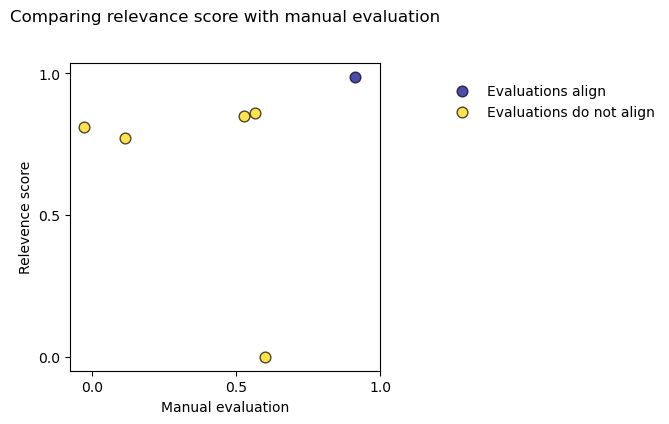

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( figsize=( 4, 4 ) )

plt1 = ax.scatter( blue_x, blue_y, s=60, alpha=0.7, c="darkblue", edgecolors="k")
plt2 = ax.scatter( gold_x, gold_y, s=60, alpha=0.7, c="gold", edgecolors="k")

plt.xticks( [ 0.0, 0.5, 1.0 ], [ 0.0, 0.5, 1.0 ] )
plt.yticks( [ 0.0, 0.5, 1.0 ], [ 0.0, 0.5, 1.0 ] )

plt.xlabel("Manual evaluation")
plt.ylabel("Relevence score")

ax.legend( ( plt1, plt2 ), ( "Evaluations align", "Evaluations do not align" ), loc=( 1.2, 0.8 ), frameon=False )
ax.set_title( "Comparing relevance score with manual evaluation", pad=30 )
print( "" )